# load models

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
from fastai.text import *

In [3]:
wiki_path = "data/wiki/"
wiki = load_learner(wiki_path, "wiki-heb.pkl")

## load the data

In [4]:
import codecs
import pandas as pd

In [5]:
np.random.seed(42)
path_r = "data/rivlin/"
data_frame = {}
for i in ["train", "test"]:
    data = list(codecs.open(f"{path_r}/token_{i}.tsv", 'r', 'utf-8').readlines())
    x, y = zip(*[d.strip().split('\t') for d in data])
    data_frame[i] = pd.DataFrame({"text": x, "label": y, "valid": i=="valid"})

# if you want to be carefull
# msk = np.random.rand(len(data_frame["train"])) < 0.8
# train = data_frame["train"][msk]
# valid = data_frame["train"][~msk]
# len(train), len(valid), len(data_frame["test"])

dataframe = pd.concat([data_frame["train"], data_frame["test"]])

## language model

In [6]:
data_lm = (TextList.from_df(dataframe, cols=["text"])
            .random_split_by_pct(0.2)
            .label_for_lm()           
            .databunch(bs=36))

In [7]:
learn = language_model_learner(data_lm, AWD_LSTM,pretrained=wiki, drop_mult=0.3)
learn.fit_one_cycle(5, 5e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,6.285755,5.453011,0.223354,00:06
1,5.388300,5.032595,0.245708,00:05
2,4.586555,4.670845,0.264491,00:05
3,3.740050,4.375226,0.299368,00:05
4,3.143991,4.325456,0.306335,00:05


In [8]:
learn.unfreeze()
learn.fit_one_cycle(4, slice(1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.883111,4.332112,0.309730,00:07
1,2.778386,4.258980,0.322781,00:07
2,2.657484,4.252689,0.327454,00:07
3,2.546900,4.249361,0.327851,00:07


In [9]:
learn.save_encoder("encoder_rivlin")

## classification

In [17]:
data_class = TextClasDataBunch.from_df("",vocab=learn.data.vocab, train_df=data_frame["train"], valid_df=data_frame["test"],# test_df=data_frame["test"],
                                      text_cols=["text"], label_cols=["label"], bs=32)
learn_class = text_classifier_learner(data_class, AWD_LSTM, drop_mult=0.5)
learn_class.load_encoder("encoder_rivlin");

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


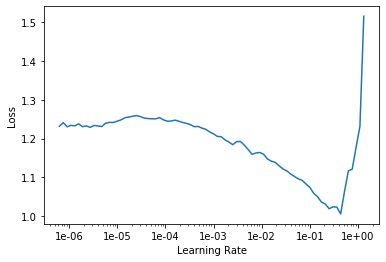

In [18]:
learn_class.lr_find()
learn_class.recorder.plot()

In [19]:
learn_class.fit_one_cycle(3, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.613803,0.470970,0.810547,00:07
1,0.562804,0.440504,0.819922,00:07
2,0.541959,0.423071,0.831641,00:07


In [20]:
learn_class.freeze_to(-2)
learn_class.fit_one_cycle(3, slice(1e-4,1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.545800,0.415012,0.830469,00:08
1,0.487235,0.415337,0.835938,00:08
2,0.515618,0.423501,0.836328,00:08


In [21]:
learn_class.freeze_to(-3)
learn_class.fit_one_cycle(3, slice(1e-4,1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.447228,0.378120,0.844141,00:10
1,0.423068,0.350405,0.857031,00:11
2,0.419075,0.379500,0.859766,00:11


In [22]:
learn_class.unfreeze()
learn_class.fit_one_cycle(10, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.409947,0.330528,0.870313,00:14
1,0.379117,0.326215,0.872656,00:13
2,0.367801,0.312985,0.886328,00:12
3,0.364022,0.341326,0.885547,00:13
4,0.285569,0.293034,0.894141,00:13
5,0.295372,0.339370,0.894141,00:13
6,0.226642,0.291129,0.898047,00:13
7,0.197265,0.295951,0.907422,00:12
8,0.199267,0.288218,0.913281,00:13
9,0.189087,0.279940,0.917188,00:13


In [23]:
learn_class.save("rivlin")

In [24]:
learn_class.fit_one_cycle(20, slice(1e-5,1e-4), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.218967,0.292004,0.913281,00:13
1,0.195559,0.275507,0.915625,00:14
2,0.237771,0.287703,0.914453,00:14
3,0.207441,0.286554,0.915234,00:13
4,0.191954,0.276237,0.919922,00:14
5,0.201283,0.284909,0.919922,00:13
6,0.174845,0.274808,0.915234,00:13
7,0.175277,0.341412,0.911328,00:13
8,0.180291,0.276024,0.921484,00:13
9,0.154926,0.283394,0.923047,00:14


In [25]:
learn_class.fit_one_cycle(20, slice(1e-6,1e-4), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.153753,0.291420,0.923828,00:13
1,0.129646,0.282673,0.925000,00:13
2,0.131551,0.287922,0.926953,00:14
3,0.122028,0.280407,0.926562,00:13
4,0.171308,0.280694,0.929688,00:14
5,0.117863,0.279557,0.928125,00:12
6,0.141222,0.283338,0.927344,00:12
7,0.120557,0.289923,0.931641,00:13
8,0.124135,0.292608,0.928125,00:13
9,0.129745,0.305329,0.927344,00:13


In [26]:
# p = learn_class.get_preds(ds_type = DatasetType.Test, ordered=True)
# results = list(map(int, data_frame["test"]["label"].values)) == np.argmax(p[0].numpy(), axis=1)
# results.sum() / len(p[1])